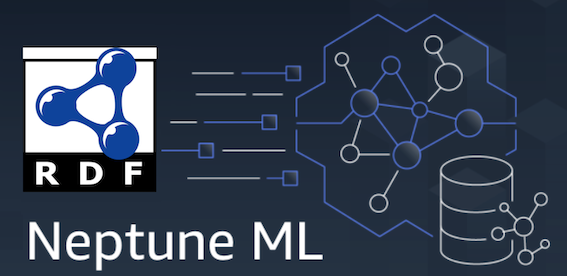

# Node Classification - Introduction
In this Notebook we are going to examine the process of using Amazon Neptune ML feature to perform RDF Literal string  classification in an RDF graph.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This notebook take approximately 1 hour to complete</div>

[Neptune ML](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview) is a feature of Amazon Neptune that enables users to automate the creation, management, and usage of Graph Neural Network (GNN) machine learning models within Amazon Neptune.  Neptune ML is built using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [Deep Graph Library](https://www.dgl.ai/) and provides a simple and easy to use mechanism to build/train/maintain these models and then use the predictive capabilities of these models within a Gremlin query to predict elements or property values in the graph. 

For this notebook we are going to show how to perform a common machine learning task known as **node classification**.  Node classification is a common semi-supervised machine learning task where a model built using existing nodes, which in RDF means existing string Literal values. Where the triple does not exist, we can predict the value of the Literal. Node classification is not unique to GNN based models (look at DeepWalk or node2vec) but the GNN based models in Neptune ML provide additional context to the predictions by combining the connectivity and features of the local neighborhood of a node to create a more predictive model.

Node classification is commonly used to solve many common buisness problems such as:

* [Identifying fradulent transactions](https://aws.amazon.com/blogs/machine-learning/detecting-fraud-in-heterogeneous-networks-using-amazon-sagemaker-and-deep-graph-library/)
* Predicting group membership in a social or identity network
* Predicting categories for product recommendation
* Predicting user churn


Neptune ML uses a four step process to automate the process of creating production ready GNN models:

1. **Load Data** - Data is loaded into a Neptune cluster using any of the normal methods such as SPARQL queries or using the Neptune Bulk Loader.
2. **Export Data** - A service call is made specifying the machine learning model type and model configuration parameters.  The data and model configuration parameters are then exported from a Neptune cluster to an S3 bucket.
3. **Model Training** - A set of service calls are made to pre-process the exported data, train the machine learning model, and then generate an Amazon SageMaker endpoint that exposes the model.
4. **Run Queries** - The final step is to use this inference endpoint within our SPARQL queries to infer data using the machine learning model via a SERVICE federated Query call.

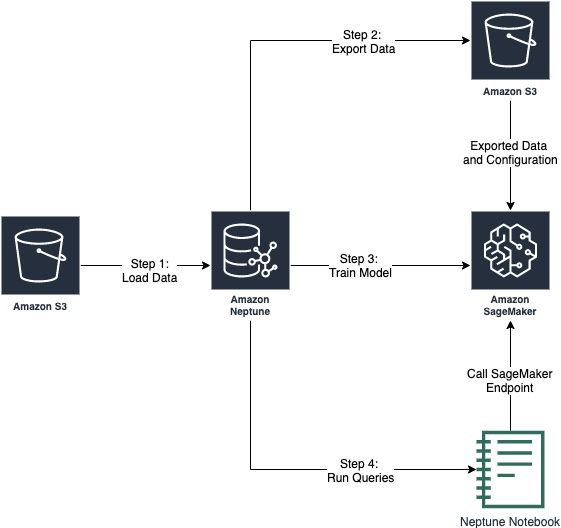



This notebook uses the [MovieLens 100k dataset](https://grouplens.org/datasets/movielens/100k/) provided by [GroupLens Research](https://grouplens.org/datasets/movielens/). This dataset consists of movies, users, and ratings of those movies by users. 

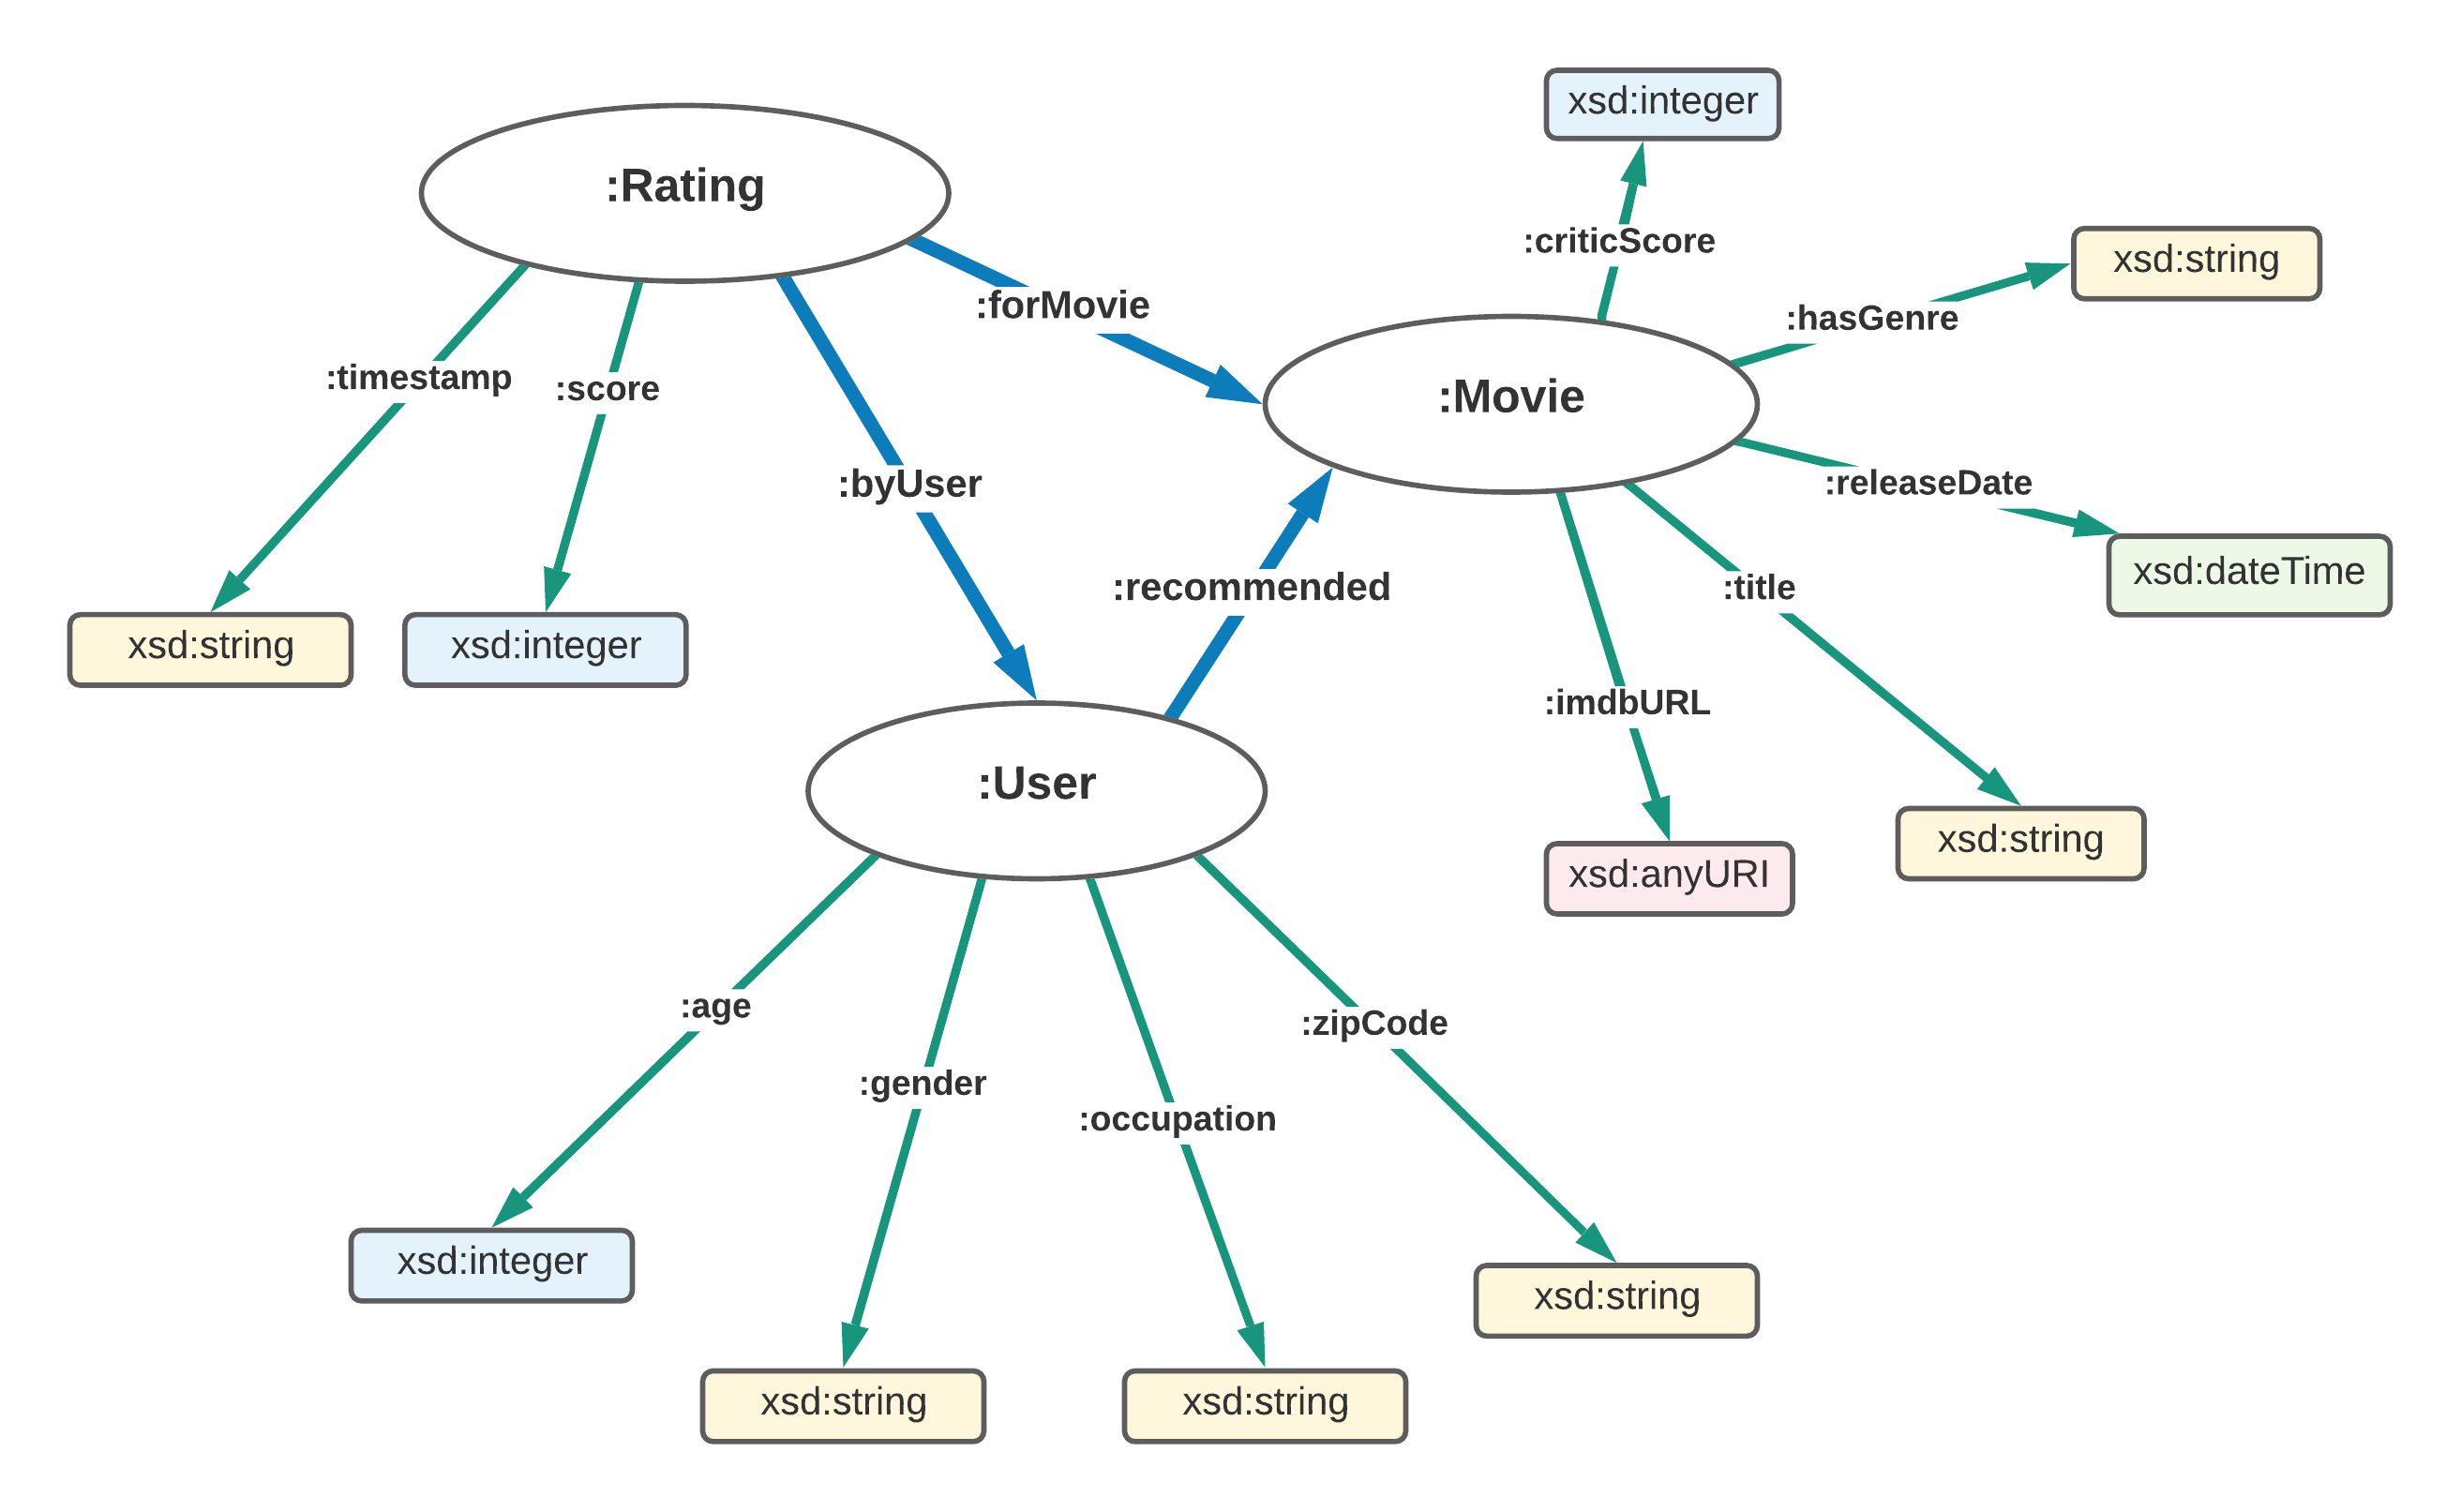

For this notebook we'll walk through how Neptune ML can predict the group membership of a product in a product knowledge graph.  To demonstrate this we'll predict the genre of new movies added to our product knowledge graph.  We'll walk through each step of loading and exporting the data, configuring and training the model, and finally we'll show how to use that model to infer the genre of movies using SPARQL queries. 

## Checking that we are ready to run Neptune ML 
Run the code below to check that this cluster is configured to run Neptune ML.

In [ ]:
import neptune_ml_sparql_utils as neptune_ml
neptune_ml.check_ml_enabled()

If the check above did not say that this cluster is ready to run Neptune ML jobs then please check that the cluster meets all the pre-requisites defined [here](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-overview).

## Loading the data 

The first step in building a Neptune ML model is to load data into the Neptune cluster. Loading data for Neptune ML follows the standard process of ingesting data into Amazon Neptune, for this example we'll be using the Bulk Loader. 

We have written a script that automates the process of downloading the data from the MovieLens websites and formatting it to load into Neptune. All you need to provide is an S3 bucket URI that is located in the same region as the cluster.

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: This is the only step that requires any specific input from the user, all remaining cells will automatically propogate the required values.</div>

In [ ]:
s3_bucket_uri="s3://<INSERT S3 BUCKET OR PATH>"
# remove trailing slashes
s3_bucket_uri = s3_bucket_uri[:-1] if s3_bucket_uri.endswith('/') else s3_bucket_uri

Now that you have provided an S3 bucket, run the cell below which will download and format the MovieLens data into a format compatible with Neptune's bulk loader.

In [ ]:
response = neptune_ml.prepare_movielens_data_rdf(s3_bucket_uri, clear_staging_area=True)

This process only takes a few minutes and once it has completed load the data using the `%load` command in the cell below.

In [ ]:
%load -s {response} -f nquads -p OVERSUBSCRIBE --run

# Export the data and model configuration

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: Before exporting data ensure that Neptune Export has been configured as described here: <a href="https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-service.html#machine-learning-data-export-service-run-export">Neptune Export Service</a></div>

With our product knowledge graph loaded we are ready to export the data and configuration which will be used to train the ML model.  

The export process is triggered by calling to the [Neptune Export service endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-service.html).  This call contains a configuration object which specifies the type of machine learning model to build, in this example node classification, as well as any feature configurations required.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The configuration used in this notebook specifies only a minimal set of configuration options meaning that our model's predictions are not as accurate as they could be.  The parameters included in this configuration are one of a couple of sets of options available to the end user to tune the model and optimize the accuracy of the resulting predictions.</div>

The configuration options provided to the export service are broken into two main sections, selecting the target and configuring features. 

## Selecting the target

In the first section, selecting the target, we specify what type of machine learning task will be run, and in the case of node classification, what the target node label and property we want to predict.  To run a node classification task we are only required to specify the node label and target property to infer. 

In this example below we specify the `genre` property on the `movie` node as our target for prediction by including these values in the `targets` sub-parameter of the `additionalParams` object as shown below. 

```
"additionalParams": {
        "neptune_ml": {
          "targets": [
            {
              "node": "movie",
              "property": "genre"
            }
          ],
          ....
```

## Configuring features
The second section of the configuration, configuring features, is where we specify details about the types of data stored in our graph and how the machine learning model should interpret that data.  In machine learning, each property is known as a feature and these features are used by the model to make predictions.  

When data is exported from Neptune all properties of all nodes are included.  Each property is treated as a separate feature for the ML model.  Neptune ML does its best to infer the correct type of feature for a property, in many cases, the accuracy of the model can be improved by specifying information about the property used for a feature.  By default Neptune ML puts features into one of two categories:

* If the feature represents a numerical property (float, double, int) then it is treated as a `numerical` feature type. In this feature type data is represented as a continuous set of numbers.  In our example, the `age` of a `user` would best be represented as a numerical feature as the age of a user is best represented as a continuous set of values.
* All other property types are represented as `category` features.  In this feature type, each unique value of data is represented as a unique value in the set of classifications used by the model.  In our MovieLens example the `occupation` of a `user` would represent a good example of a `category` feature as we want to group users that all have the same job.

If all of the properties fit into these two feature types then no configuration changes are needed at the time of export.  However, in many scenarios these defaults are not always the best choice.  In these cases, additional configuration options should be specified to better define how the property should be represented as a feature. 

One common feature that needs additional configuration is numerical data, and specifically properties of numerical data that represent chunks or groups of items instead of a continuous stream.

Let's say that instead of wanting `age` to be represented as a set of continuous values we want to represent it as a set of discrete buckets of values (e.g. 18-25, 26-24, 35-44, etc.).  In this scenario we want to specify some additional attributes of that feature to bucket this attribute into certain known sets.  We achieve this by specifying this feature as a `numerical_bucket`.  This feature type takes a range of expected values, as well as a number of buckets, and groups data into buckets during the training process.

Another common feature that needs additional attributes are text features such as names, titles, or descriptions.  While Neptune ML will treat these as categorical features by default the reality of these features is that they will likely be unique for each node.  For example, since  the `title` property of a `movie` node does not fit into a category grouping our model would be better served by representing this type of feature as a `text_word2vec` feature.  A `text_word2vec` feature uses techniques from natural language processing to create a vector of data that represents a string of text.  

In our export example below we have specified that the `title` property of our `movie` should be exported and trained as a `text_word2vec` feature and that our `age` field should range from 0-100 and that data should be bucketed into 10 distinct groups.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Important</b>: The example below is an example of a minimal amount of the features of the model configuration parameters and will not create the most accurate model possible.  Additional options are available for tuning this configuration to produce an optimal model are described here: <a href="https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-parameters.html">Neptune Export Process Parameters</a></div>

Running the cell below we set the export configuration and run the export process.  Neptune export is capable of automatically creating a clone of the cluster by setting `cloneCluster=True` which takes about 20 minutes to complete and will incur additional costs while the cloned cluster is running.  Exporting from the existing cluster takes about 5 minutes but requires that the `neptune_query_timeout` parameter in the [parameter group](https://docs.aws.amazon.com/neptune/latest/userguide/parameters.html) is set to a large enough value (>72000) to prevent timeout errors.

In [ ]:
export_params={
  "command": "export-rdf",
  "params": {
    "endpoint": neptune_ml.get_host(),
    "useIamAuth": neptune_ml.get_iam(),
    "cloneCluster": False,
    "profile": "neptune_ml"
  },
    "outputS3Path": f'{s3_bucket_uri}/neptune-export',
  "additionalParams": {
    "neptune_ml": {
      "version": "v2.0",
      "targets": [
            {
              "node" : "http://aws.amazon.com/neptune/ontology/Movie",
              "predicate" : "http://aws.amazon.com/neptune/ontology/hasGenre",
              "type": "classification",
              "split_rate": [0.7,0.1,0.2]
            }
          ]
    }
  },
"jobSize": "medium"}



In [ ]:
%%neptune_ml export start --export-url {neptune_ml.get_export_service_host()} --export-iam --wait --store-to export_results
${export_params}

# ML data processing, model training, and endpoint creation

Once the export job is completed we are now ready to train our machine learning model and create the inference endpoint. Training our Neptune ML model requires three steps.  
  
<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The cells below only configure a minimal set of parameters required to run a model training.</div>

## Data processing 
The first step (data processing) processes the exported graph dataset using standard feature preprocessing techniques to prepare it for use by DGL. This step performs functions such as feature normalization for numeric data and encoding text features using word2vec. At the conclusion of this step the dataset is formatted for model training. 

This step is implemented using a SageMaker Processing Job and data artifacts are stored in a pre-specified S3 location once the job is complete.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Data Processing](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-processing.html)
* [dataprocessing command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-dataprocessing.html)

Run the cells below to create the data processing configuration and to begin the processing job.

In [ ]:
# The training_job_name can be set to a unique value below, otherwise one will be auto generated
training_job_name=neptune_ml.get_training_job_name('node-classification')

processing_params = f"""
--config-file-name training-data-configuration.json
--job-id {training_job_name} 
--s3-input-uri {export_results['outputS3Uri']} 
--s3-processed-uri {str(s3_bucket_uri)}/preloading """

In [ ]:
%neptune_ml dataprocessing start --wait --store-to processing_results {processing_params}

## Model training
The second step (model training) trains the ML model that will be used for predictions. The model training is done in two stages. The first stage uses a SageMaker Processing job to generate a model training strategy. A model training strategy is a configuration set that specifies what type of model and model hyperparameter ranges will be used for the model training. Once the first stage is complete, the SageMaker Processing job launches a SageMaker Hyperparameter tuning job. The SageMaker Hyperparameter tuning job runs a pre-specified number of model training job trials on the processed data, and stores the model artifacts generated by the training in the output S3 location. Once all the training jobs are complete, the Hyperparameter tuning job also notes the training job that produced the best performing model.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Model Training](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-model-training.html)
* [modeltraining command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-modeltraining.html)

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: The model training process takes ~20 minutes</div>

In [ ]:
training_params=f"""
--job-id {training_job_name} 
--data-processing-id {training_job_name}
--instance-type ml.p3.2xlarge
--s3-output-uri {str(s3_bucket_uri)}/training """

In [ ]:
%neptune_ml training start --wait --store-to training_results {training_params}

## Endpoint creation

The final step is to create the inference endpoint which is an Amazon SageMaker endpoint instance that is launched with the model artifacts produced by the best training job. This endpoint will be used by our graph queries to  return the model predictions for the inputs in the request. The endpoint once created stays active until it is manually deleted. Each model is tied to a single endpoint.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Inference Endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-inference-endpoint.html)
* [Endpoint command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-endpoints.html)

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: The endpoint creation process takes ~5-10 minutes</div>

In [ ]:
endpoint_params=f"""
--id {training_job_name}-2 
--model-training-job-id {training_job_name} """

print(endpoint_params)

In [ ]:
%neptune_ml endpoint create --wait --store-to endpoint_results {endpoint_params}

Once this has completed we get the endpoint name for our newly created inference endpoint.  The cell below will set the endpoint name which will be used in the SPARQL queries below. 

In [ ]:
endpoint=endpoint_results['endpoint']['name']
neptune_role=neptune_ml.get_neptune_ml_role()

# Predicting values using SPARQL queries

Now that we have our inference endpoint setup let's query our product knowledge graph to show how to predict categorical property values by predicting the the genre for movies, starting with `Empire Strikes Back, The (1980)`.  

## Predicting movie genres

<br>
<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Object Classification</b> - This model is trained to allow for inferring the `ontology:genre` string literal value of an instance of the `ontology:Movie` rdf:Class.      
    
   Example `resource:movie_225` `ontology:genre` `"[to be predicted]"` . 
   
In order to make our prediction, we need to remove some data.  
Run the following query to remove the Genre's for three Movie's: 

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

DELETE {
    ?movie  ontology:hasGenre ?genre
}
WHERE { 
    ?movie  ontology:hasGenre ?genre ;
            ontology:title  ?title .
            
    FILTER (?title IN (
        "Empire Strikes Back, The (1980)",
        "Mars Attacks! (1996)",
        "Independence Day (ID4) (1996)"
    ))
}

Now that we have run the above query, three movies do not have any Genre's classified against them.

Run the following query to verify that the Genre's in question were removed:

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre WHERE { 
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
            
    OPTIONAL {
          ?movie  ontology:hasGenre ?genre .
    }
    
    FILTER (?title IN (
        "Empire Strikes Back, The (1980)",
        "Mars Attacks! (1996)",
        "Independence Day (ID4) (1996)"
    ))

} 

As expected there is no Genre in the result set, so let's modify this query to predict the genre for `Empire Strikes Back, The (1980)`. To accomplish this we need to add more statements to our query:

1. Include a `SERVICE` enclosure to federate the Query to our ML endpoint. To do this you must use a special pre-defined URI which we have designated to use for ML calls:
`SERVICE <http://aws.amazon.com/neptune/vocab/v01/services/ml#inference> {...} `


2. Add the configuration statements needed to connect to the ML endpoint you have created and specify the type of prediction.

* ` ... ml:config ml:endpoint "{endpoint}" ...` - The ML endpoint that has been created. <div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The endpoint values are automatically passed into the queries below</div>

* ` ...ml:config ml:modelType 'OBJECT_CLASSIFICATION' ` - The inference type being used in this prediction. As we are predicting the OBJECT of the `'SUBJECT - PREDICATE - OBJECT'` standard RDF model.


3. Build the model of the RDF statement you are predicting: Add the following statements to the body of the SERVICE enclosure, so that you can build the SUBJECT, PREDICATE and OBJECT of your prediction.

* ` ...ml:config ml:input ?input ` - The input of the prediction is the `'rdf:Subject'` of the predicted full statement using the  `'SUBJECT - PREDICATE - OBJECT'` standard RDF model.

* ` ...ml:config ml:predicate ontology:hasGenre ` - The predicate of the prediction is the `'rdf:Predicate'` of the predicted full statement using the `'SUBJECT - PREDICATE - OBJECT'` standard RDF model.

* ` ...ml:config ml:output ?output ` - The output of the prediction is the `'rdf:Object'` of the predicted full statement using the `'SUBJECT - PREDICATE - OBJECT'` standard RDF model.


4. <div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Add optional stataments</b>:</div>
* ` ...ml:config ml:score ?score ` - The calculated confidence of the prediction from DGL (Deep Graph Library).

* ` ...ml:config ml:limit "3" ` - The number of predictions to return from DGL (Deep Graph Library).

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre ?score WHERE { 
    
    BIND (resource:movie_172 as ?movie)
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${endpoint}" ;
                         # the optional 'score' predicate   
                         ml:outputScore ?score ;
                         # the optional 'limit' predicate   
                         ml:limit "1" ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ; 
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?genre ;
        }     
} 

Looking at the results, this prediction seems right for the top result, `Empire Strikes Back, The (1980)` seems to fit well into the `Drama` genre, but the other predictions do not seem correct, so we can set a threshold for the score:  

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?genre ?score WHERE { 
    
    BIND (resource:movie_172 as ?movie)
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
            
    OPTIONAL {
          ?movie  ontology:hasGenre ?genre .
    }
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${endpoint}" ;
                         ml:outputScore ?score ;
                         ml:threshold "0.5D" ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ;
                         ml:limit "3" ;
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?genre ;
        }     
} 

The results that do not meet the threshold are removed.

As we see, depending on the threshold value specified the results where the confidence does not meet that threshold are removed.

So far we have only been working on a single movie, but let's say you wanted to predict the genre for all movies without a `genre`.

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?score ?predictedGenre WHERE { 
    
    ?movie a ontology:Movie ;
            ontology:title  ?title.
            
    MINUS {
          ?movie  ontology:hasGenre ?existingGenre .
    }
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${endpoint}" ;
                         ml:outputScore ?score ; 
                         ml:threshold "0.5D" ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ;
                         ml:limit "3" ;
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?predictedGenre .
    }
    
} 

We have applied the filters shown above to this query to find the top 3 genres for all our "new" movies, as long as the prediction has >70% confidence.

Now that we've seen how to use Neptune ML to predict these categories, the next question is, how good are the predictions.  

## Comparing the accuracy of predicted and actual genres
Run the query below to see the predicted versus actual genres for one of our movies.

In [ ]:
%%sparql

PREFIX  ml: <http://aws.amazon.com/neptune/vocab/v01/services/ml#>
PREFIX  ontology: <http://aws.amazon.com/neptune/ontology/>
PREFIX  resource: <http://aws.amazon.com/neptune/resource#>

SELECT ?title ?existingGenre ?predictedGenre ?score WHERE { 
    
     BIND('Boxing Helena (1993)' as ?title)
    
    ?movie a ontology:Movie ;
            ontology:title  ?title ;
            ontology:hasOriginalGenre ?existingGenre .
    
    SERVICE ml:inference { 
               ml:config ml:endpoint "${endpoint}" ;
                         ml:outputScore ?score ; 
                         ml:limit 3 ;
                         ml:modelType 'OBJECT_CLASSIFICATION' ; 
                         ml:input ?movie ; 
                         ml:predicate ontology:hasGenre ;  
                         ml:output ?predictedGenre .
    }
    
    FILTER (?predictedGenre = ?existingGenre)
    
} limit 10


Comparing the `existingGenre` versus the `predictedGenre` results we see that our model did a good job of predicting the genres for this Movie.

# Cleaning up 
Now that you have completed this walkthrough you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done trying out Neptune ML and would like to avoid these recurring costs, run the cell below to delete the inference endpoint.


In [ ]:
neptune_ml.delete_endpoint(training_job_name)

In [ ]:
print(training_job_name)

In addition to the inference endpoint the CloudFormation script that you used has setup several additional resources.  If you are finished then we suggest you delete the CloudFormation stack to avoid any recurring charges. For instructions, see Deleting a Stack on the [Deleting a Stack on the Amazon Web Services CloudFormation Console](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/cfn-console-delete-stack.html). Be sure to delete the root stack (the stack you created earlier). Deleting the root stack deletes any nested stacks.